# Chapter 15: Cluster Analysis (Edited by Kang)


> (c) 2019-2020 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.
>
> Date: 2020-03-08
>
> Python Version: 3.8.2
> Jupyter Notebook Version: 5.6.1
>
> Packages:
>   - matplotlib: 3.2.0
>   - numpy: 1.18.1
>   - pandas: 1.0.1
>   - scipy: 1.4.1
>   - scikit-learn: 0.22.2
>
> The assistance from Mr. Kuber Deokar and Ms. Anuja Kulkarni in preparing these solutions is gratefully acknowledged.


In [1]:
# Import required packages for this chapter
from pathlib import Path

import pandas as pd
import numpy as np
from pandas.plotting import parallel_coordinates
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import matplotlib.pylab as plt

%matplotlib inline

In [2]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('.')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

# Problem 15.1: University Rankings
The dataset on American College and University Rankings (available from www.dataminingbook.com) contains information on 1302 American colleges and universities offering an undergraduate program. For each university, there are 17 measurements, including continuous measurements (such as tuition and graduation rate) and categorical measurements (such as location by state and whether it is a private or public school).

Note that many records  are missing some measurements. Our first goal is to estimate these missing values from "similar" records. This will be done by clustering the complete records and then finding the closest cluster for each of the partial records.  The missing values will be imputed from the information in that cluster.

## Solution 15.1.a
Remove all records with missing measurements from the dataset. 

In [3]:
# Load data
full_df = pd.read_csv('Universities.csv')

print('Before: ', full_df.shape)
universities_df = full_df.dropna(axis=0)
print('After: ', universities_df.shape)

universities_df.head()

Before:  (1302, 20)
After:  (471, 20)


,College Name,State,Public (1)/ Private (2),# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
0,Alaska Pacific University,AK,2,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,7560.0,1620.0,2500.0,130.0,800.0,1500.0,76.0,11.9,15.0
2,University of Alaska Southeast,AK,1,146.0,117.0,89.0,4.0,24.0,492.0,1849.0,1742.0,5226.0,2514.0,2250.0,34.0,500.0,1162.0,39.0,9.5,39.0
9,Birmingham-Southern College,AL,2,805.0,588.0,287.0,67.0,88.0,1376.0,207.0,11660.0,11660.0,2050.0,2430.0,120.0,400.0,900.0,74.0,14.0,72.0
11,Huntingdon College,AL,2,608.0,520.0,127.0,26.0,47.0,538.0,126.0,8080.0,8080.0,1380.0,2540.0,100.0,500.0,1100.0,63.0,11.4,44.0
21,Talladega College,AL,2,4414.0,1500.0,335.0,30.0,60.0,908.0,119.0,5666.0,5666.0,1424.0,1540.0,418.0,1000.0,1400.0,56.0,15.5,46.0


## Solution 15.1.b
For all the continuous measurements, run hierarchical clustering using complete linkage and Euclidean distance. For simplicity, drop all categorical varaibles (college name, state, and public/private).  Make sure to normalize the measurements. From the dendrogram: How many clusters seem reasonable for describing these data?

In [4]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   College Name              1302 non-null   object 
 1   State                     1302 non-null   object 
 2   Public (1)/ Private (2)   1302 non-null   int64  
 3   # appli. rec'd            1292 non-null   float64
 4   # appl. accepted          1291 non-null   float64
 5   # new stud. enrolled      1297 non-null   float64
 6   % new stud. from top 10%  1067 non-null   float64
 7   % new stud. from top 25%  1100 non-null   float64
 8   # FT undergrad            1299 non-null   float64
 9   # PT undergrad            1270 non-null   float64
 10  in-state tuition          1272 non-null   float64
 11  out-of-state tuition      1282 non-null   float64
 12  room                      981 non-null    float64
 13  board                     804 non-null    float64
 14  add. fee

In [6]:
help(dendrogram)

Help on function dendrogram in module scipy.cluster.hierarchy:

dendrogram(Z, p=30, truncate_mode=None, color_threshold=None, get_leaves=True, orientation='top', labels=None, count_sort=False, distance_sort=False, show_leaf_counts=True, no_plot=False, no_labels=False, leaf_font_size=None, leaf_rotation=None, leaf_label_func=None, show_contracted=False, link_color_func=None, ax=None, above_threshold_color='b')
    Plot the hierarchical clustering as a dendrogram.
    
    The dendrogram illustrates how each cluster is
    composed by drawing a U-shaped link between a non-singleton
    cluster and its children.  The top of the U-link indicates a
    cluster merge.  The two legs of the U-link indicate which clusters
    were merged.  The length of the two legs of the U-link represents
    the distance between the child clusters.  It is also the
    cophenetic distance between original observations in the two
    children clusters.
    
    Parameters
    ----------
    Z : ndarray
       

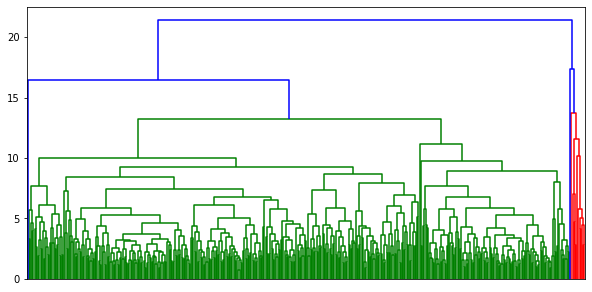

In [8]:
# Reduce to continuous measurements and normalize data
reduced_df = universities_df.drop(columns=['College Name', 'State', 'Public (1)/ Private (2)'])
universities_norm = (reduced_df - reduced_df.mean()) / reduced_df.std()
# Hierarchical clustering using complete linkage and Euclidean distance 
Z = linkage(universities_norm,  method='complete')
fig = plt.figure(figsize=(10, 5))
dendrogram(Z, no_labels=True)
plt.show()

In [10]:
help(fcluster)

Help on function fcluster in module scipy.cluster.hierarchy:

fcluster(Z, t, criterion='inconsistent', depth=2, R=None, monocrit=None)
    Form flat clusters from the hierarchical clustering defined by
    the given linkage matrix.
    
    Parameters
    ----------
    Z : ndarray
        The hierarchical clustering encoded with the matrix returned
        by the `linkage` function.
    t : scalar
        For criteria 'inconsistent', 'distance' or 'monocrit',
         this is the threshold to apply when forming flat clusters.
        For 'maxclust' or 'maxclust_monocrit' criteria,
         this would be max number of clusters requested.
    criterion : str, optional
        The criterion to use in forming flat clusters. This can
        be any of the following values:
    
          ``inconsistent`` :
              If a cluster node and all its
              descendants have an inconsistent value less than or equal
              to `t` then all its leaf descendants belong to the
     

In [17]:
# try splitting into different number of clustesr
memb = fcluster(Z,14,criterion='distance')
np.unique(memb, return_counts=True)

(array([1, 2, 3, 4], dtype=int32), array([457,   1,  12,   1]))

## Solution 15.1.c
Compare the summary statistics for each cluster and describe each cluster in this context (e.g., "Universities with high tuition, low acceptance rate...").  (_Hint_: To obtain cluster statistics for hierarchical clustering, use the pandas method _groupby(clusterlabel)_ together with methods such as _mean_ or _median_.) 

In [18]:
centroids = {}
for key, item in reduced_df.groupby(memb):
    centroids['Cluster {}'.format(key)] = item.mean()

pd.DataFrame(centroids).round(2)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4
# appli. rec'd,2752.12,601.0,17750.33,11054.0
# appl. accepted,1793.08,396.0,12118.50,6397.0
# new stud. enrolled,684.50,203.0,4263.92,3524.0
% new stud. from top 10%,27.87,1.0,35.92,26.0
% new stud. from top 25%,55.35,20.0,70.25,55.0
# FT undergrad,3084.42,525.0,20961.58,16502.0
# PT undergrad,684.84,323.0,3372.42,21836.0
in-state tuition,9476.47,11230.0,7114.75,3171.0
out-of-state tuition,10577.70,11230.0,10559.42,8949.0
room,2210.63,3843.0,2545.42,1498.0
